In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
from PIL import Image

### 文件路径

In [2]:
# dataDir='/home/wsg/dataset/visdrone-2019/val/images/'
# dataType='val2017'
# annFile='/home/wsg/dataset/visdrone-2019/val/annotations_VisDrone_val.json'
dataDir='/home/wsg/dataset/coco-2017/validation/data'
dataType='val2017'
annFile='/home/wsg/dataset/coco-2017/validation/labels.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [8]:
imgIds = coco.getImgIds()
annIds = coco.getAnnIds(imgIds=imgIds[0], iscrowd=None)

In [9]:
len(annIds)

19

In [10]:
# 统计instance分布
box_num_count = [len(coco.getAnnIds(imgIds=imgid, iscrowd=None)) for imgid in coco.getImgIds()]
import pandas as pd
b_num_count = pd.Series(box_num_count)
b_num_count.describe()  

count    5000.000000
mean        7.356200
std         7.438978
min         0.000000
25%         2.000000
50%         4.000000
75%        10.000000
max        63.000000
dtype: float64

### 查看类别

In [3]:
# 打印coco 80个类别以及12个超类
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
pedestrian people bicycle car van truck tricycle awning-tricycle bus motor others

COCO supercategories: 
none


### 类名名称与id的互换，加载图像信息

In [4]:
# 获取类别的id，图片的id
catIds = coco.getCatIds(catNms=['pedestrian','car','bus'])
imgIds = coco.getImgIds(catIds=catIds) #找到同时包含person、dog和skateboard的图片
# imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [5]:
# for img_id in coco.getImgIds():
img

{'id': 355,
 'license': 1,
 'height': 765,
 'width': 1360,
 'file_name': '0000327_04001_d_0000731.jpg'}

In [48]:
# 筛选出所有尺寸小于32*32的gt
small_img_ids = {}
for ann in coco.loadAnns(coco.getAnnIds()):
    bbox = ann['bbox']
    area = bbox[2]*bbox[3]
    img_id = ann['image_id']
    ann_id = ann['id']
    if area < 32*32:
        small_img_ids.append[img_id]

    

[{'segmentation': [[510.66,
    423.01,
    511.72,
    420.03,
    510.45,
    416.0,
    510.34,
    413.02,
    510.77,
    410.26,
    510.77,
    407.5,
    510.34,
    405.16,
    511.51,
    402.83,
    511.41,
    400.49,
    510.24,
    398.16,
    509.39,
    397.31,
    504.61,
    399.22,
    502.17,
    399.64,
    500.89,
    401.66,
    500.47,
    402.08,
    499.09,
    401.87,
    495.79,
    401.98,
    490.59,
    401.77,
    488.79,
    401.77,
    485.39,
    398.58,
    483.9,
    397.31,
    481.56,
    396.35,
    478.48,
    395.93,
    476.68,
    396.03,
    475.4,
    396.77,
    473.92,
    398.79,
    473.28,
    399.96,
    473.49,
    401.87,
    474.56,
    403.47,
    473.07,
    405.59,
    473.39,
    407.71,
    476.68,
    409.41,
    479.23,
    409.73,
    481.56,
    410.69,
    480.4,
    411.85,
    481.35,
    414.93,
    479.86,
    418.65,
    477.32,
    420.03,
    476.04,
    422.58,
    479.02,
    422.58,
    480.29,
    423.01,
    4

### 数据标签可视化

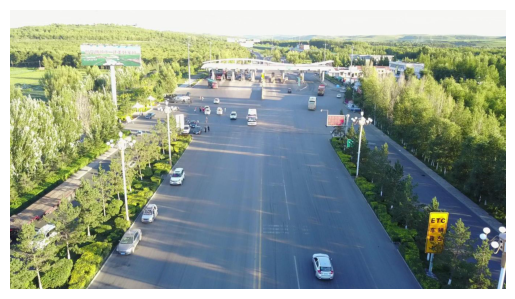

In [23]:
# I = io.imread(img['coco_url'])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
import os
I = Image.open(os.path.join(dataDir,img["file_name"]))
plt.axis('off')
plt.imshow(I)
plt.show()

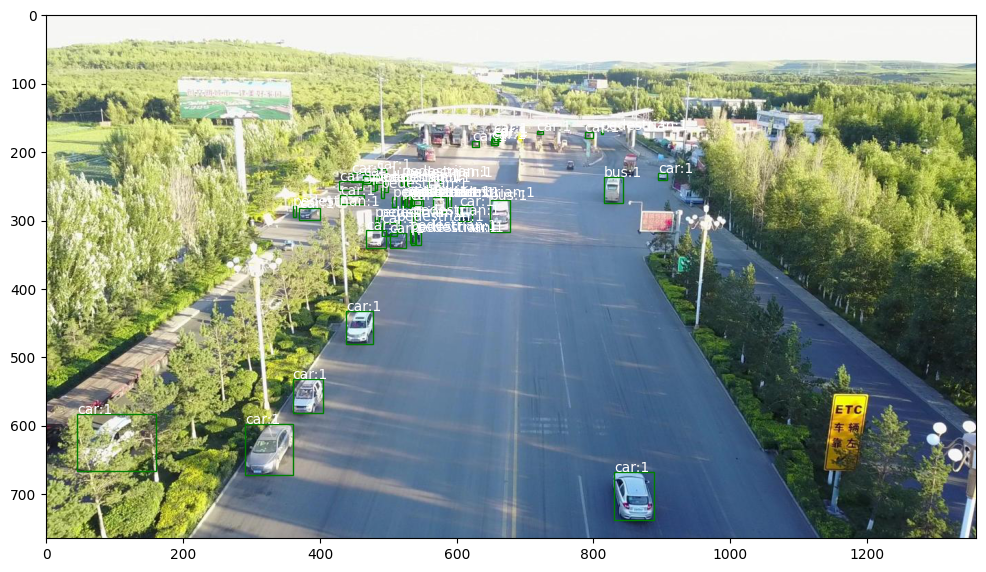

In [24]:
# load and display instance annotations
import matplotlib.patches as patches

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

boxes = []
labels = []
scores = []
for ann in anns:
    boxes.append(ann["bbox"])
    labels.append(ann["category_id"])
    scores.append(ann.get("score",1))
    
classes = [cat['name'] for cat in cats]

_, ax = plt.subplots(1, figsize=(12,9))
image = np.array(I)
ax.imshow(image)



for box, label, score in zip(boxes,labels,scores):
    if score > 0.5:
        # if label>len(classes):print("error!",label)
        # coco 数据集存在标签错误？？！ 竟然出现83的索引，似乎并不是标错了。
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='g', facecolor='none')
        # 为了清晰，不显示gt的类别和置信度
        # if show_label:
        ax.annotate(classes[label-1] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=10)
        ax.add_patch(rect)
plt.show()

In [12]:
anns[1]

{'id': 13247,
 'image_id': 355,
 'category_id': 4,
 'bbox': [946, 663, 160, 68],
 'area': 10880,
 'iscrowd': 0,
 'ignore': 0}

In [23]:
result_json = "/home/geng/tinyml/ppq/benchmark/dynamic_shape_quant/FP32_model/Retinanet-wo-dynamic-trt-FP32.bbox.json"
cocoDt = coco.loadRes(result_json)

Loading and preparing results...
DONE (t=6.02s)
creating index...
index created!


In [28]:
imgIds=sorted(coco.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [34]:
cocoEval = COCOeval(coco,cocoDt,"bbox")
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.90s).
Accumulating evaluation results...
DONE (t=0.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.588
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100